In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pandas_datareader
#import pandas_datareader.moex as moex
import utils.moex as moex

# Параметр для вывода на экран всех строк таблиц
pd.set_option('display.max_columns', None)
#plt.rcParams['figure.dpi'] = 200 # 200

In [32]:
# Чистка описания акции от суффиксов
def remove_suffix(series):
    rep_pattern = '|'.join(('ао', 'ап', '-п', '-гдр', '-адр', ' др'))
    a = series.str.replace(rep_pattern, '', regex=True)
    return a.str.rstrip('3').str.rstrip('-').str.rstrip(' ')

In [33]:
# Грузим стоки с Мос.Биржи
imoex = moex.get_stocks_in_indices('IMOEX')
moexbmi = moex.get_stocks_in_indices('MOEXBMI')

# Объединяем данные по индексам
df = pd.DataFrame()
df['name']=moexbmi['shortnames']
df['moexbmi']=moexbmi['weight']
df['imoex']=imoex['weight']
df.fillna(0, inplace=True)
df = df[(df['moexbmi']>0) | (df['imoex']>0)]

imoex_stocks_count = df[df['imoex']>0].shape[0]
moexbmi_stocks_count = df[df['moexbmi']>0].shape[0]

https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics/IMOEX.csv?iss.only=analytics&limit=100&start=0
https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics/MOEXBMI.csv?iss.only=analytics&limit=100&start=0


In [34]:
# Грузим последние цены
a = moex.get_stocks()[['LOTSIZE','LAST']]

df['LOTSIZE'] = a['LOTSIZE']
df['LAST'] = a['LAST']
df['price'] = df['LOTSIZE']*df['LAST']

# Чистим наименования от суффиксов
df['shortname'] = remove_suffix(df['name'])

# Группируем по компаниям
df = df.groupby('shortname').agg({'imoex': 'sum', 'moexbmi': 'sum', 'price': 'mean'}).sort_values('moexbmi', ascending=False)

imoex_company_count = df[df['imoex']>0].shape[0]
moexbmi_company_count = df[df['moexbmi']>0].shape[0]

# Приводим веса к числу с плавующей точнкой
df['imoex'] = df['imoex'] / df['imoex'].sum()
df['moexbmi'] = df['moexbmi'] / df['moexbmi'].sum()

print(f'Количество акций|компаний в IMOEX: {imoex_stocks_count}|{imoex_company_count}')
print(f'Количество акций|компаний в MOEXBMI: {moexbmi_stocks_count}|{moexbmi_company_count}')

Количество акций|компаний в IMOEX: 43|40
Количество акций|компаний в MOEXBMI: 98|90


# Расчитываем свой индекс

Ограничение максимального веса за счёт перераспределения избыточного веса в пользу малых весов

In [35]:
# Ограничение максимального веса
def coeff(df, indexname, max_weight):
    su = df[indexname].sum()
    i = df[df[indexname]>0].shape[0]
    b = (max_weight * su - df[indexname].max()) / (1-i*max_weight)
    return (df[df[indexname]>0][indexname] + b) / (su + i*b)

def coeff2(df, indexname, max_weight):
    temp = df[indexname].copy()
    su = temp.sum()
    temp[temp>0.10]=0.10

    #i = df[df[indexname]>0].shape[0]
    #b = (max_weight * su - df[indexname].max()) / (1-i*max_weight)
    return temp/su

In [36]:
#df['imoex50']  = coeff(df[0:50], 'moexbmi', 0.1)
df['imoex+']  = coeff(df[(df['moexbmi']>0.001) | (df['imoex']>0) ], 'imoex', 0.13)
#df['imoexd'] = coeff2(df[(df['moexbmi']>0.001) | (df['imoex']>0) ], 'imoex', 0.1)
#df['imoexd'].sum()

Сравнение индексов

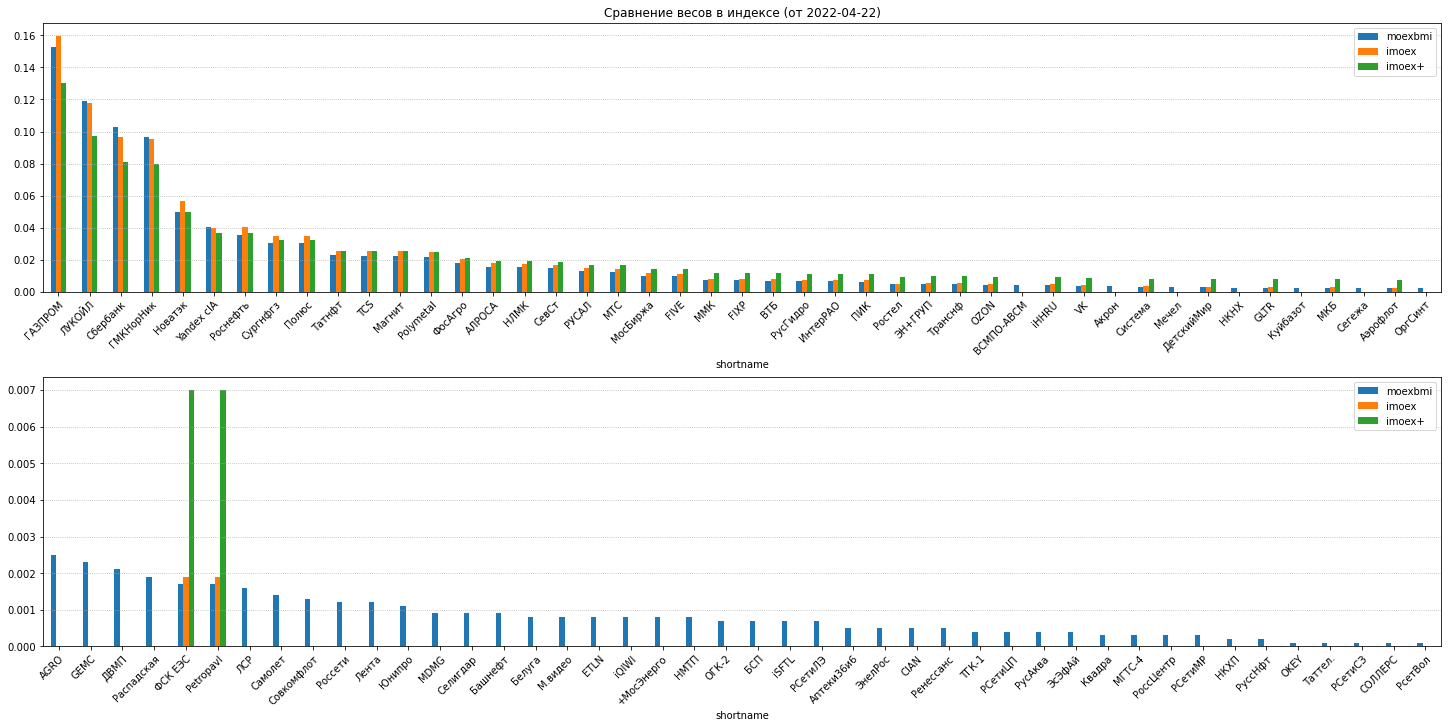

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
fig.set_size_inches(20,10)
nn = round(df.shape[0]/2)
df[['moexbmi', 'imoex',  'imoex+']][0:nn].plot.bar(ax=ax1)
df[['moexbmi', 'imoex',  'imoex+']][nn:-1].plot.bar(ax=ax2)

ax1.grid(axis='y', linestyle=':')
ax2.grid(axis='y', linestyle=':')
ax1.set_title(f'Сравнение весов в индексе (от {datetime.date.today()})')
plt.setp([ax1.xaxis.get_majorticklabels(),ax2.xaxis.get_majorticklabels()], ha="right" , rotation=45, rotation_mode="anchor");

## Загрузка портфеля

In [38]:
# Количество акций
cc={
    'AFKS':1000, #Система ао
    'AFLT':120, #Аэрофлот
    'ALRS':290, #АЛРОСА ао
    'CBOM':3300, #МКБ ао
    'CHMF':21, #СевСт-ао
    'DSKY':170, #ДетскийМир
    'FEES':100000, #ФСК ЕЭС ао
    'FIVE':9, #FIVE-гдр
    'GAZP':660, #ГАЗПРОМ ао
    'GLTR':10, #GLTR-гдр
    'GMKN':4, #ГМКНорНик
    'HHRU':2, #iHHRU-адр
    'HYDR':27000, #РусГидро
    'IRAO':4100, #ИнтерРАОао
    'KMEZ':1, #КМЗ
    'LKOH':27, #ЛУКОЙЛ
    'LNTA':60, #Лента др
    'LSRG':25, #ЛСР ао
    'MAGN':600, #ММК
    'VKCO':11, #MAIL-гдр
    'MGNT':6, #Магнит ао
    'MOEX':140, #МосБиржа
    'MTSS':80, #МТС-ао
    'NLMK':130, #НЛМК ао
    'NVTK':50, #Новатэк ао
    'OZON':6, #OZON-адр
    'PHOR':7, #ФосАгро ао
    'PIKK':50, #ПИК ао
    'PLZL':3, #Полюс
    'POGR':300, #Petropavl
    'POLY':23, #Polymetal
    'QIWI':2, #iQIWI
    'ROSN':87, #Роснефть
    'RSTI':7000, #Россети ао
    'RSTIP':4000, #Россети ап
    'RTKM':100, #Ростел -ао
    'RTKMP':110, #Ростел -ап
    'RUAL':660, #РУСАЛ ао
    'SBER':410, #Сбербанк
    'SBERP':290, #Сбербанк-п
    'SNGS':600, #Сургнфгз
    'SNGSP':500, #Сургнфгз-п
    'TATN':32, #Татнфт 3ао
    'TATNP':35, #Татнфт 3ап
    'TCSG':13, #TCS-гдр
    'UPRO':7000, #Юнипро ао
    'VTBR':540000, #ВТБ ао
    'YNDX':19, #Yandex clA
    'FIXP': 14, #Fix Price
    'ENPG': 8 # ЭН+Груп ао
}

In [39]:
dd = moex.get_stocks()
#print(dd)
portfolio = pd.DataFrame.from_dict(cc, orient='index', columns=['SecNum'])
portfolio = portfolio.join(dd)[['SHORTNAME','SecNum','LAST', 'LOTSIZE']]
portfolio['Value'] = portfolio['SecNum']*portfolio['LAST']

c = portfolio #pd.DataFrame(b.items(), columns=['shortnames','portfolio'])
c['ShortName'] = remove_suffix(c['SHORTNAME'])
# Группируем по компаниям
c = c.groupby('ShortName').sum().sort_values('Value', ascending=False)
portfolio_value = c['Value'].sum()
c['Weight']=c['Value']/c['Value'].sum()
df = pd.concat([df,c], axis=1)
df.fillna(0, inplace=True)
df

,imoex,moexbmi,price,imoex+,SecNum,LAST,LOTSIZE,Value,Weight
ГАЗПРОМ,0.159768,0.152931,2080.00,0.130000,660.0,208.00,10.0,137280.0,0.124579
ЛУКОЙЛ,0.117676,0.119124,3800.00,0.097206,27.0,3801.00,1.0,102627.0,0.093132
Сбербанк,0.096681,0.102621,1203.85,0.080848,700.0,240.77,20.0,83835.7,0.076079
ГМКНорНик,0.095581,0.096719,19686.00,0.079991,4.0,19686.00,1.0,78744.0,0.071459
Новатэк,0.056689,0.050110,982.80,0.049689,50.0,983.00,1.0,49150.0,0.044603
...,...,...,...,...,...,...,...,...,...
РСетиСЗ,0.000000,0.000100,302.00,0.000000,0.0,0.00,0.0,0.0,0.000000
СОЛЛЕРС,0.000000,0.000100,1840.00,0.000000,0.0,0.00,0.0,0.0,0.000000
РсетВол,0.000000,0.000100,308.50,0.000000,0.0,0.00,0.0,0.0,0.000000
АшинскийМЗ,0.000000,0.000100,2235.00,0.000000,0.0,0.00,0.0,0.0,0.000000


Сравнение веса акций в потфеле с весами в индексе

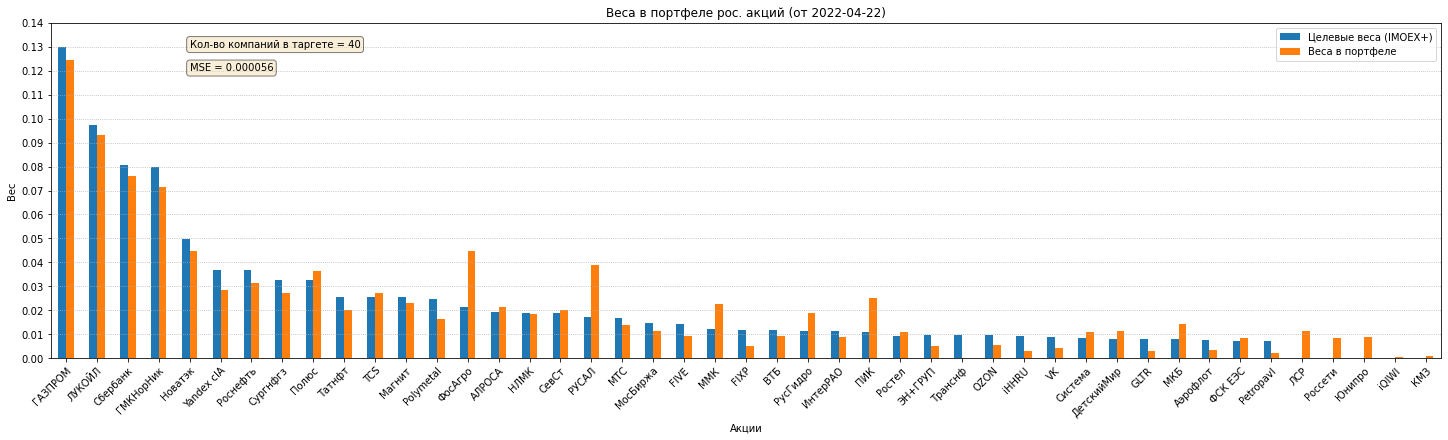

In [40]:
fig ,ax  = plt.subplots(constrained_layout=True)
fig.set_size_inches(20,6)
target_index_name = 'imoex+'

partdf = df[(df[target_index_name]>0) | (df['Weight']>0)]
mse = ((partdf[target_index_name]-partdf['Weight'])**2).mean()

#ax = imoex[['weight', 'myIMOEX', 'portfolio']].plot.bar()
partdf[[target_index_name,'Weight']].plot.bar(ax =ax )
plt.yticks(np.arange(0, df[target_index_name].max()+0.01, 0.01))
ax.grid(axis='y', linestyle=':')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
k = 0.07
ax.text(0.10, 0.95, f"Кол-во компаний в таргете = {df[df[target_index_name]>0].shape[0]}", transform=ax.transAxes, verticalalignment='top', bbox=props)
ax.text(0.10, 0.95-k, f"MSE = {mse:0.6f}", transform=ax.transAxes, verticalalignment='top', bbox=props)

ax.set_title(f'Веса в портфеле рос. акций (от {datetime.date.today()})')
ax.set_ylabel('Вес')
ax.set_xlabel('Акции')

plt.setp(
    ax.xaxis.get_majorticklabels(),
    ha="right" , 
    rotation=45,
    rotation_mode="anchor");

plt.legend(labels=[f'Целевые веса ({target_index_name.upper()})','Веса в портфеле']);

# Рекомендации к покупке

## Семплирование

In [41]:
partdf['prior']=partdf['imoex+']-partdf['Weight']
partdf.sort_values(by='prior', inplace=True, ascending=False)
partdf

/tmp/ipykernel_8792/1395943669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partdf['prior']=partdf['imoex+']-partdf['Weight']
/tmp/ipykernel_8792/1395943669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partdf.sort_values(by='prior', inplace=True, ascending=False)


,imoex,moexbmi,price,imoex+,SecNum,LAST,LOTSIZE,Value,Weight,prior
Транснф,0.005499,0.004801,108100.00,0.009806,0.0,0.000000,0.0,0.0,0.000000,0.009806
Polymetal,0.024895,0.022004,778.00,0.024918,23.0,778.000000,1.0,17894.0,0.016239,0.008680
ГМКНорНик,0.095581,0.096719,19686.00,0.079991,4.0,19686.000000,1.0,78744.0,0.071459,0.008532
Yandex clA,0.040192,0.040708,1651.00,0.036836,19.0,1652.000000,1.0,31388.0,0.028484,0.008352
FIXP,0.008198,0.007201,385.60,0.011910,14.0,385.600000,1.0,5398.4,0.004899,0.007011
iHHRU,0.004799,0.004301,1720.00,0.009261,2.0,1720.000000,1.0,3440.0,0.003122,0.006139
Татнфт,0.025795,0.022805,330.40,0.025619,67.0,660.800000,2.0,22080.7,0.020038,0.005581
Роснефть,0.040292,0.035607,397.95,0.036914,87.0,398.000000,1.0,34626.0,0.031423,0.005492
ГАЗПРОМ,0.159768,0.152931,2080.00,0.130000,660.0,208.000000,10.0,137280.0,0.124579,0.005421
Сургнфгз,0.034693,0.030706,2763.75,0.032552,1100.0,55.275000,200.0,29905.0,0.027138,0.005414


In [42]:
'''
def func1(x):
    a = cc['Value']+ x * cc['price']
    b = (cc[target_index_name]*a.sum()-a)**2
    return b.sum()

cc = partdf[partdf[target_index_name]>0]

money = 20000
s_len = cc.shape[0]
x0 = np.zeros(s_len)
bnds = [(0, None) for n in range(0,s_len)]
cons = {'type':'eq', 'fun': lambda x: np.sum(x*cc['price'])-money}
res = minimize(func1, x0, method='SLSQP', bounds=bnds, constraints=cons)
res
#partdf['priority'] = partdf[target_index_name]-partdf['Weight']
#a = partdf[partdf['priority']>0].sort_values('priority', ascending=False)
#a

'''

"\ndef func1(x):\n    a = cc['Value']+ x * cc['price']\n    b = (cc[target_index_name]*a.sum()-a)**2\n    return b.sum()\n\ncc = partdf[partdf[target_index_name]>0]\n\nmoney = 20000\ns_len = cc.shape[0]\nx0 = np.zeros(s_len)\nbnds = [(0, None) for n in range(0,s_len)]\ncons = {'type':'eq', 'fun': lambda x: np.sum(x*cc['price'])-money}\nres = minimize(func1, x0, method='SLSQP', bounds=bnds, constraints=cons)\nres\n#partdf['priority'] = partdf[target_index_name]-partdf['Weight']\n#a = partdf[partdf['priority']>0].sort_values('priority', ascending=False)\n#a\n\n"

In [43]:
hh = {
    'FXUS': 7479,
    'FXCN': 113,
    'FXDE': 11465,
    'VTBX': 103,
    'TSPX': 6598,
    'SBSP': 91
}

gr = {
    'FXUS': 'US',
    'FXCN': 'CH',
    'FXDE': 'DE',
    'VTBX': 'RU',
    'TSPX': 'US',
    'SBSP': 'US'
}
gr = pd.Series(gr,index=gr.keys())

tw = {
    'RU': 0.5,
    'US': 0.25,
    'DE': 0.125,
    'CH': 0.125
}
tw = pd.Series(tw,index=tw.keys())

In [44]:
import datetime
date = datetime.datetime.today()
shift = datetime.timedelta(max(1,(date.weekday() + 6) % 7 - 3))
edate = date - shift
df = pandas_datareader.DataReader(hh.keys(), 'moex',start=edate)
df = df[df['BOARDID']=='TQTF'][['SECID', 'WAPRICE']]
df.set_index('SECID', inplace=True)
df['Count'] = pd.Series(hh,index=hh.keys())
df['Value'] = df['Count']* df['WAPRICE']
df['gr'] = gr 

gdf = df.groupby('gr')['Value'].sum().to_frame()
gdf.loc['RU'] += c['Value'].sum()
gdf['Weight'] = gdf['Value']/gdf['Value'].sum()
gdf

/tmp/ipykernel_8792/3914020922.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = pandas_datareader.DataReader(hh.keys(), 'moex',start=edate)
/tmp/ipykernel_8792/3914020922.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = pandas_datareader.DataReader(hh.keys(), 'moex',start=edate)
/tmp/ipykernel_8792/3914020922.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = pandas_datareader.DataReader(hh.keys(), 'moex',start=edate)
/tmp/ipykernel_8792/3914020922.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = pandas_datareader.DataReader(hh.keys(), 'moex',start=edate)
/tmp/ipykernel_8792/3914020922.py:5: FutureWarning: 

,Value,Weight
gr,,
CH,0,0.0
DE,0,0.0
RU,1111270.4,1.0
US,0,0.0


In [45]:
ddd

NameError: name 'ddd' is not defined

In [ ]:
df

In [ ]:
y = np.array([3052, 30, 1, 61])

def func2(x):
    a = gdf['Value']+x*y
    b = (tw*a.sum()-a)**2
    return b.sum()

func2([0,10,0,50])

In [ ]:
from scipy.optimize import minimize
money = 20000
x0 = np.zeros(4)
bnds = ((0, None) for n in range(0,4))
cons = {'type':'eq', 'fun': lambda x: np.sum(x*y)-money}
res = minimize(func2, x0, method='SLSQP', bounds=bnds, constraints=cons)
res

In [ ]:
gdf['Buy']= np.round(res.x)
gdf['Invest']= gdf['Buy']*y
gdf

In [ ]:
from cvxopt import glpk

In [ ]:
type(np.linspace(1,50))

In [ ]:
np.getsizeof(np.arange(1,4))

In [ ]:
type(np.zeros(5))

In [ ]:
type([3,4,5])

In [ ]:
pd.set_option('display.max_rows', None)
dd.loc[['SBER', 'GAZP']]

In [ ]:
1200000*(0.06*2)/100